# 1. Download data and Setup


In [ ]:
#!pip3 install wldhx.yadisk-direct

In [3]:
# !curl -L $(yadisk-direct https://disk.yandex.ru/d/9yMyAhVNw_tvLA) -o data.zip

In [7]:
# !unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/aspects.csv        
  inflating: data/features.csv       
  inflating: data/organisations.csv  
  inflating: data/reviews.csv        
  inflating: data/rubrics.csv        
  inflating: data/test_users.csv     
  inflating: data/users.csv          


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm.auto import tqdm
import typing as tp
import plotly
import random
from tqdm.auto import tqdm

tqdm.pandas()

np.random.seed(2022)
random.seed(2022)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2. Data preparation and Cleaning

In [135]:
reviews_df = pd.read_csv('data/reviews.csv').rename(columns= {'aspects' : 'aspect_ids', 'rating':'review_rating'},)

users_df = pd.read_csv('data/users.csv').rename(columns = {'city': 'user_city'})
test_users_df = pd.read_csv('data/test_users.csv')
organisations_df = pd.read_csv('data/organisations.csv').rename(columns={'city': 'org_city', 'rating': 'org_rating'})

rubrics_df = pd.read_csv('data/rubrics.csv')
features_df = pd.read_csv('data/features.csv')
aspects_df = pd.read_csv('data/aspects.csv')

/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
rubrics_df.info(), features_df.info(), aspects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rubric_id    15 non-null     int64 
 1   rubric_name  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 368.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_id    1006 non-null   int64 
 1   feature_name  1006 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   aspect_id    243 non-null    int64 
 1   aspect_name  243 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


(None, None, None)

As assumed sizes reviews_dfof `dict` dataframe is small. But let's imagine it's huge :)


In [4]:
# reviews_df.aspect_ids = pd.to_numeric(reviews_df.aspect_ids)

In [5]:
reviews_df.explode('aspect_ids')

,user_id,org_id,review_rating,ts,aspect_ids
0,5969205021826098131,15999570556361329805,1.0,279,NaN
1,11419028914633614269,15999570556361329805,1.0,391,NaN
2,11971839180212507821,15999570556361329805,1.0,419,NaN
3,3849350083734153986,15999570556361329805,1.0,641,NaN
4,6903065064138938065,15999570556361329805,1.0,654,NaN
...,...,...,...,...,...
4129691,907604215316834814,219245207864793974,4.0,982,97
4129692,2245592011385839678,219245207864793974,5.0,448,97
4129693,5691026343836404728,14687570877891213266,2.0,1127,97
4129694,11193314027500612304,1205510582855082798,5.0,1001,97


In [6]:
def apply_func_to_each_columns(df: pd.DataFrame, columns_to_apply: list[str], func: tp.Callable) -> None:
    new_df = df.copy()
    for column in columns_to_apply:
        # rows_without_NAN = ~df[column].isnull()
        # df.loc[rows_without_NAN, column] = df.loc[rows_without_NAN, column].apply(func)
        new_df[column] = df[column].apply(func)
        
    return new_df

parse_str_to_int_list = lambda line: [int(number) for number in str(line).split(' ') if number.isnumeric()]

1. in `reviews` parse `aspect_ids`

In [7]:
reviews = apply_func_to_each_columns(reviews_df, ['aspect_ids'], parse_str_to_int_list)

reviews.aspect_ids.apply(len).sort_values(ascending=False)


3646404    15
3867655    14
3646855    14
3632205    14
3809694    14
           ..
1376570     0
1376571     0
1376572     0
1376573     0
2064848     0
Name: aspect_ids, Length: 4129696, dtype: int64

In [8]:
reviews = reviews.explode('aspect_ids').rename(columns={'aspect_ids': 'aspect_id'}) # same function also in spark
reviews.sample(10)

# or do smth like: https://stackoverflow.com/questions/39954668/how-to-convert-column-with-list-of-values-into-rows-in-pandas-dataframe
# https://stackoverflow.com/questions/45846765/efficient-way-to-unnest-explode-multiple-list-columns-in-a-pandas-dataframe

# >>> s = df.apply(lambda x: pd.Series(x['samples']), axis=1).stack().reset_index(level=1, drop=True)
# >>> s.name = 'sample'
# >>> df.drop('samples', axis=1).join(s)

,user_id,org_id,review_rating,ts,aspect_id
2896631,229425976098127178,17292100939536682647,3.0,679,NaN
3672042,16874620654240530563,11427946889796726844,5.0,1156,267
3918783,2020161878602313605,4176108691529323966,5.0,25,265
2206782,5313458781801270324,16444928614807344345,5.0,1206,NaN
1002351,9818407012068264498,1427695528613762065,5.0,1140,NaN
3353762,3064623136350032078,4594011633420927733,5.0,744,NaN
2649272,9026371437099015800,5718418596353227955,3.0,1086,NaN
2473092,18375136522233841854,6129601420560555512,5.0,835,NaN
3302014,2515715014433407707,5742705483529187651,5.0,1013,NaN
2553444,13814904045016888096,15919482492715844882,5.0,425,NaN


As u can see instead of `4129696` we got `4585254`

2. in `organisations` parse `features_ids`

In [9]:
organisations_df.features_id

0        3501685156 3501779478 20422 3502045016 3502045...
1        1509 1082283206 273469383 10462 11617 35017794...
2        10462 11177 11617 11629 1416 1018 11704 11867 ...
3        3501618484 2020795524 11629 11617 1018 11704 2...
4        11617 10462 11177 1416 11867 3501744275 20282 ...
                               ...                        
68334    1018 1415 10462 11629 11867 20422 20424 118949...
68335    11634 11629 3501481353 11177 3501773763 11867 ...
68336    20422 11867 246 3501754799 3501779478 12048 35...
68337    3491142672 3501481353 11867 20422 273469383 11...
68338    3501498189 3501509030 3501498184 12309 20422 3...
Name: features_id, Length: 68339, dtype: object

In [10]:
organisations = apply_func_to_each_columns(organisations_df, ['features_id', 'rubrics_id'], parse_str_to_int_list)

organisations = organisations.explode('features_id') \
                             .explode('rubrics_id') \
                             .rename(columns={'features_id': 'feature_id', 'rubrics_id': 'rubric_id'})

organisations.sample(10)


,org_id,org_city,average_bill,org_rating,rubric_id,feature_id
65503,3728393500911044816,spb,1000.0,4.577778,30776,3501481353
14378,4365770885606692016,spb,500.0,4.700000,31495,3501745827
58402,12458691864921036268,spb,500.0,4.152542,30776,3501513153
33526,16377585093291514129,msk,1000.0,4.181818,31401,20422
55340,4373450798536241368,msk,NaN,3.969697,30774,20422
36489,16161879390952478621,spb,NaN,NaN,30770,11629
63797,6093159996422930978,msk,1500.0,NaN,30776,256
29307,15635531236542873290,msk,500.0,3.998634,30771,1415
58990,15627596723391133804,spb,500.0,NaN,30774,11177
62363,17685525691353954335,msk,2000.0,4.386986,30776,11629


In [11]:
organisations.shape, organisations_df.shape

((1004751, 6), (68339, 6))

So we have `1004751` instead of `68339` len dataframe

In [12]:
%%time

full_review_info = reviews \
    .merge(organisations, on='org_id', how='left') \
    .merge(users_df, on='user_id', how='left') \
    .merge(aspects_df, on='aspect_id', how='left') \
    .merge(features_df, on='feature_id', how='left') \
    .merge(rubrics_df, on='rubric_id')


CPU times: user 2min 50s, sys: 1min 33s, total: 4min 24s
Wall time: 4min 24s


In [13]:
full_review_info.sample(10)

,user_id,org_id,review_rating,ts,aspect_id,org_city,average_bill,org_rating,rubric_id,feature_id,user_city,aspect_name,feature_name,rubric_name
85742529,17913019607399519371,6664350636076147652,1.0,583,NaN,msk,500.0,4.266667,30775,11704,msk,NaN,wi_fi,Пиццерия
97655185,10405407735547291462,14803105372140225878,5.0,943,4,spb,500.0,4.250000,30770,20424,spb,Еда,price_category,"Бар, паб"
116707659,1220830570075314678,16327095963630245962,1.0,575,267,msk,NaN,3.697151,30771,11177,msk,Чай,breakfast,Быстрое питание
111769041,11576520981468855512,1212502960035640455,2.0,959,NaN,msk,500.0,4.334694,30771,3501749289,msk,NaN,closed_for_visitors,Быстрое питание
11868192,9312540573052556317,16327095963630245962,5.0,1273,NaN,msk,NaN,3.697151,30774,1076799212,spb,NaN,mcexpress,Кафе
44988750,3928830865617394177,9755115000265538221,5.0,733,NaN,spb,NaN,4.445575,30776,3501481353,spb,NaN,projector,Ресторан
118900848,16657807763200908305,199252321913224408,5.0,1182,NaN,spb,NaN,4.380684,31495,3501498389,spb,NaN,free transfer,Кофейня
117678146,14350758550460120470,7657737654778456349,3.0,535,17,spb,500.0,4.301449,30771,11177,spb,Шаверма,breakfast,Быстрое питание
116722012,12590011418621898564,8037928576994158448,1.0,928,267,msk,NaN,4.326752,30771,20424,msk,Чай,price_category,Быстрое питание
58215430,8234783575766018808,5072738578507807787,5.0,605,NaN,msk,1000.0,4.506986,30776,3501513153,msk,NaN,tag_menu,Ресторан


In [14]:
full_review_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127825382 entries, 0 to 127825381
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        uint64 
 1   org_id         uint64 
 2   review_rating  float64
 3   ts             int64  
 4   aspect_id      object 
 5   org_city       object 
 6   average_bill   float64
 7   org_rating     float64
 8   rubric_id      object 
 9   feature_id     object 
 10  user_city      object 
 11  aspect_name    object 
 12  feature_name   object 
 13  rubric_name    object 
dtypes: float64(3), int64(1), object(8), uint64(2)
memory usage: 14.3+ GB


`14.3+ GB` Looks not okey, but in real task we wouldn't use pandas in production

# 3. Split mechanism, Metrics

## Metric calc

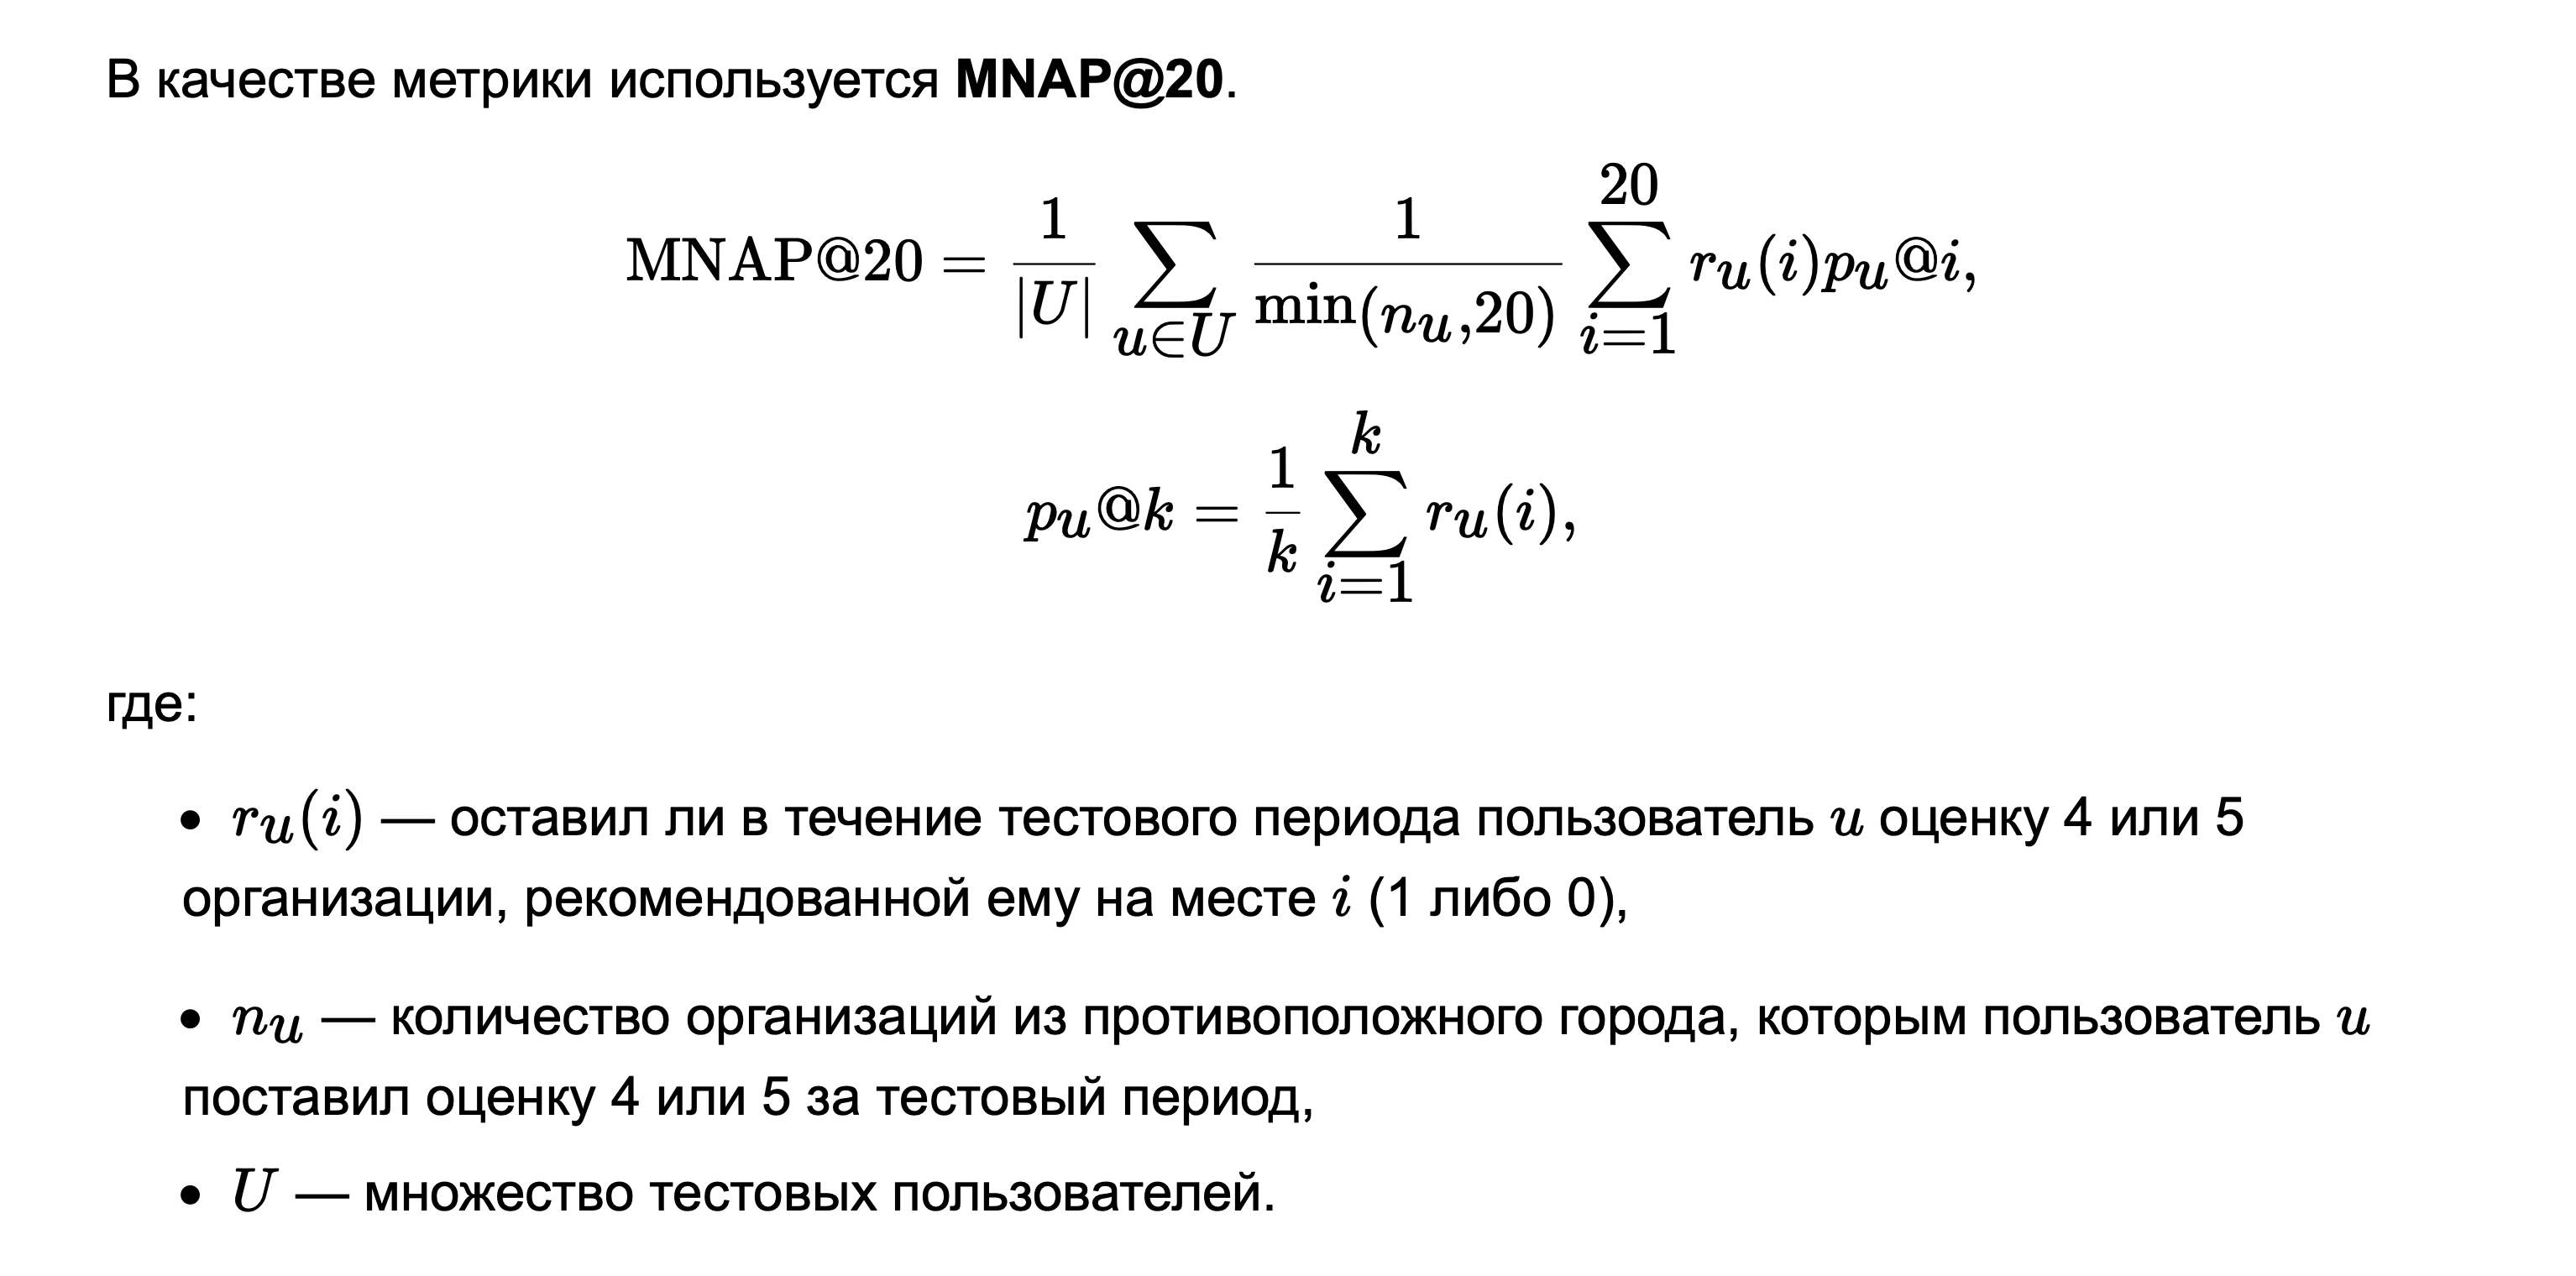

In [27]:
def MNAP(size=20):       
    def metric(y_true, predictions, size=size):
        predictions = predictions.rename(columns={'target': 'predictions'})
        merged = y_true.merge(predictions, on='user_id')
    
        def score(x, size=size):          
            y_true = x[1][1]
            predictions = x[1][2][:size]
            
            weight = 0
            inner_weights = [0]
            
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)
    
        return np.mean([score(row) for row in merged.iterrows()])
    
        
    return metric

## Splitting

In [16]:
def review_split(reviews, percentage=0.33, end_ts_values=None):
    if end_ts_values is None:
        end_ts_values = reviews.ts.max()
    
    reviews_cut = reviews[reviews.ts < end_ts_values]
    ts_percentile = reviews_cut.ts.quantile(0.33)
    
    reviews_train = reviews_cut[reviews_cut.ts <= ts_percentile]
    reviews_test = reviews_cut[reviews_cut.ts >= ts_percentile]    
    
    return reviews_train, reviews_test

In [17]:
train, test = review_split(full_review_info)
train.shape, test.shape

((42227002, 14), (85618578, 14))

## Answering

In [18]:
test_users = test_users_df.merge(users_df, on='user_id', how='left')
test_users.user_city.value_counts()

msk    19029
spb     3456
Name: user_city, dtype: int64

So, for each user in test we know his destination

In [96]:
y_test = test_users_df \
    .merge(reviews[['user_id', 'org_id']], on='user_id', how='left') \
    .groupby('user_id') \
    .agg({'org_id': list}) \
    .rename(columns={'org_id': 'y_true'}) \
    .reset_index()

y_test.y_true = y_test.y_true.apply(lambda x: list(map(int, x)))

In [97]:
y_test.dtypes

user_id    uint64
y_true     object
dtype: object

In [20]:
def make_answer(df, name):
    ans = df.copy()
    ans['target'] = ans['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
    ans.to_csv(f'{name}.csv', index=None)
    
    del ans

In [28]:
N_PREDICTION_ORG = 20

mnap_metric_calc = MNAP(N_PREDICTION_ORG)

In [31]:
pred_example = pd.DataFrame(
{
    'user_id': [1175872067657083, 3960211634564871],
    'target': [[5326072468960064989,  9293289382222853816,  3361065379355406105, 380393201136864076, 16397358758595904644],
               [16996585379035144871, 14585266011799937129, 13220328679916389818, 13882403132669515214, 18021456929242079630]
              ]
}
)

y_test_example = pd.DataFrame(
{
    'user_id': [1175872067657083, 3960211634564871],
    'y_true': [[3099370727209496142, 5326072468960064989, 14037457789472617093, 4433870819289787251, 11006800892303205642],
               [10868679817509284366, 13220328679916389818]
              ]
}
)


In [32]:
mnap_metric_calc(y_test_example, pred_example)

0.18333333333333335

# 4. baselines

Simple baselines without using any Machine Learning

## Random recommendation

In [34]:
msk_orgs = full_review_info[full_review_info['org_city'] == 'msk']['org_id'].unique()
spb_orgs = full_review_info[full_review_info['org_city'] == 'spb']['org_id'].unique()

len(msk_orgs), len(spb_orgs)

(45619, 22720)

In [35]:
# import functools
# functools.partial

random_choose_org = lambda x: np.random.choice(spb_orgs, N_PREDICTION_ORG, replace=False) if x['user_city'] == 'msk' else np.random.choice(msk_orgs, N_PREDICTION_ORG, replace=False)

target = test_users.apply(random_choose_org, axis=1)

In [36]:
result_random = test_users[['user_id']].copy()
result_random['target'] = target


In [37]:
y_test.shape, result_random.shape

((22485, 2), (22485, 2))

In [44]:
result_random.merge(y_test, on='user_id').sample(10)

,user_id,target,y_true
16868,14633171782851322853,"[12454525412902198085, 11218019101392238711, 4...","[13730233750976174314, 2787156097552998474, 11..."
17568,3031978000135456738,"[5696833996459062817, 15788148632233890150, 54...","[11006800892303205642, 10382281594135798475, 1..."
20053,17908969283618987579,"[9243025813592328873, 14017993842420089842, 13...","[3432151593601609433, 7824224429364335211, 756..."
16572,612933854916714492,"[12981183737349217927, 7256833316788929358, 15...","[14299038106324100783, 3290745739241311464, 15..."
17003,8031530490302329253,"[1161546094295717314, 12368228128599732964, 74...","[1352900198295267165, 2195361217477256866, 111..."
2284,12869715996591675718,"[14905610313433618054, 9675524123436578073, 11...","[1435674414900395919, 2645993823236004281, 123..."
222,17064760978885603717,"[13941432392042473131, 7870406827290866253, 10...","[11598849612575836677, 8628711277418501758, 79..."
10849,17240385623564938799,"[10295641935307348321, 3799567149887107179, 16...","[2004179479792092234, 6721526179323412826]"
22166,14447881977804036742,"[9917483987007302684, 15743962532501255514, 74...","[3189471572895390546, 8754130794036124532, 747..."
2051,14715457714563610142,"[10421132470345218153, 13547277892034259676, 1...","[14471364305557264390, 2966606192252052550, 12..."


In [43]:
mnap_metric_calc(y_test, result_random) * 100

0.004379863195415152

In [40]:
make_answer(result_random, 'result_random')
result_random

,user_id,target
0,11859048046981233908,"[14291813952693371814, 18296442805684883655, 1..."
1,15587804372050325574,"[13064952707297140827, 12938310779546936379, 4..."
2,12162067348356020196,"[6078548748694935743, 12012994269630510588, 11..."
3,8103517504171274389,"[5676502108179280826, 10140635697863404537, 11..."
4,10945514241898471401,"[13579648093647152602, 3474339525900168788, 86..."
...,...,...
22480,13566530607351820237,"[8848644278010639406, 627582383648898705, 5079..."
22481,11335509666663005941,"[12184245054450841626, 2164819459233967618, 96..."
22482,9661327606538591652,"[4834325459763527595, 5927972744371606715, 118..."
22483,14022370448741367741,"[7589842432295673357, 9019275552152928424, 120..."


## Recommend most popular places with high rate

In [203]:
msk_orgs = full_review_info[(full_review_info['org_city'] == 'msk') & (full_review_info['org_rating'] > 4)]['org_id']
spb_orgs = full_review_info[(full_review_info['org_city'] == 'spb') & (full_review_info['org_rating'] > 4)]['org_id']

print(f'Msk good org reviews ratio {len(msk_orgs) / (full_review_info[full_review_info["org_city"] == "msk"].shape[0])}')
print(f'SPB good org reviews ratio {len(spb_orgs) / (full_review_info[full_review_info["org_city"] == "spb"].shape[0])}')

msk_orgs = msk_orgs.value_counts().index[:N_PREDICTION_ORG].to_list()
spb_orgs = spb_orgs.value_counts().index[:N_PREDICTION_ORG].to_list()

Msk good org reviews ratio 0.874799915272791
SPB good org reviews ratio 0.89232099201243


In [204]:
rng = np.random.default_rng()
rng.choice([1, 2, 3, 1], size = 3, replace=False)
# Interesting details about np.random.choices withoud duplication
# https://ymd_h.gitlab.io/ymd_blog/posts/numpy_random_choice/

array([3, 1, 2])

In [205]:
# random_choose_org = lambda x: np.random.choice(spb_orgs, size = N_PREDICTION_ORG, replace=False) if x['user_city'] == 'msk' else np.random.choice(msk_orgs, N_PREDICTION_ORG, replace=False)
random_choose_org = lambda x: np.random.choice(spb_orgs, size = N_PREDICTION_ORG, replace=False) if x['user_city'] == 'msk' else np.random.choice(msk_orgs, N_PREDICTION_ORG, replace=False)

target = test_users.progress_apply(random_choose_org, axis=1)
target = target.progress_apply(lambda x: list(map(int, x)))

result_top_N = test_users[['user_id']].copy()
result_top_N['target'] = target

  0%|          | 0/22485 [00:00<?, ?it/s]

  0%|          | 0/22485 [00:00<?, ?it/s]

In [206]:
result_top_N.merge(y_test, on='user_id').apply(lambda x: sum([i in x['y_true'] for i in x['target']]), axis=1).sort_values(ascending=False)

0        0
14988    0
14996    0
14995    0
14994    0
        ..
7493     0
7492     0
7491     0
7490     0
22484    0
Length: 22485, dtype: int64

In [196]:
mnap_metric_calc(y_test, result_top_N) * 100

0.0831595696295419

In [207]:
make_answer(result_top_N, 'result_top_N')
result_top_N

,user_id,target
0,11859048046981233908,"[1732348878070501632, 15092837550836111360, 53..."
1,15587804372050325574,"[11006800892303206400, 11710076672100157440, 1..."
2,12162067348356020196,"[14811007832067758080, 11266259534819315712, 3..."
3,8103517504171274389,"[16515799056215097344, 5019267650883348480, 19..."
4,10945514241898471401,"[1352900198295267072, 17483411528870660096, 17..."
...,...,...
22480,13566530607351820237,"[1352900198295267072, 1732348878070501632, 532..."
22481,11335509666663005941,"[1732348878070501632, 3099370727209496064, 171..."
22482,9661327606538591652,"[15120040193672648704, 1876636121854267392, 15..."
22483,14022370448741367741,"[12309025298401949696, 10276373697321246720, 1..."


## Recommend from each category

todo

# 5. [Model] Collaborative filtering & ALS

1. Make interaction matrix for MSK places
2. Make interaction matrix for SPB places
3. use `implicit.als`
4. `recommend_all` and transformer into appropirate format

In [209]:
import implicit

In [225]:
def filter_reviews(reviews, users=None, orgs=None): 
    '''
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации. 

    '''
    if users is not None: 
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)
        
    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)
        
    return reviews

## Interaction matrix

In [226]:
def reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13):
    
    inner_reviews = reviews[reviews['user_city'] == reviews['org_city']]
    outer_reviews = reviews[reviews['user_city'] != reviews['org_city']]

    tourist_users = outer_reviews['user_id'].unique()
    inner_reviews = filter_reviews(inner_reviews, users=tourist_users)
    
    top_users = count_unique(inner_reviews, 'user_id')
    top_users = top_users[top_users['count'] >= min_user_reviews]
        
    top_orgs = count_unique(inner_reviews, 'org_id')
    top_orgs = top_orgs[top_orgs['count'] >= min_org_reviews]
        
    inner_reviews = filter_reviews(inner_reviews, users=top_users, orgs=top_orgs)
    outer_reviews = filter_reviews(outer_reviews, users=top_users)
    
    reviews = pd.concat([inner_reviews, outer_reviews])
    users = reviews['user_id'].unique()
    orgs = reviews['org_id'].unique()
    
    
    return (
        (
            inner_reviews,
            inner_reviews['org_id'].unique()
        ),
        (
            outer_reviews,
            outer_reviews['org_id'].unique()
        ),
        inner_reviews['user_id'].unique()
    )

In [227]:
def create_mappings(df, column):
    '''
    create_mappings(df, column)
        Создаёт маппинг между оригинальными ключами словаря и новыми порядковыми.
        
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame с данными.
            
        column : str
            Название колонки, содержащей нужны ключи. 
        
        Returns
        -------
        code_to_idx : dict
            Словарь с маппингом: "оригинальный ключ" -> "новый ключ".
        
        idx_to_code : dict
            Словарь с маппингом: "новый ключ" -> "оригинальный ключ".
    '''
    
    code_to_idx = {}
    idx_to_code = {}
    
    for idx, code in enumerate(df[column].to_list()):
        code_to_idx[code] = idx
        idx_to_code[idx] = code
        
    return code_to_idx, idx_to_code


def map_ids(row, mapping):
    '''
    Вспомогательная функция
    '''
    
    return mapping[row]


def interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12): 
    '''
    Parameters
    ---------
    min_user_reviews : int, default=5
        Minumal user feedbacks to include him in matrix

    min_org_reviews : int, default=12
        Same but with orgs

    Returns
    -------
    InteractionMatrix : scipy.sparse.csr_matrix
             ---------------------------------------------------
            | TRAIN USERS, INNER ORGS | TRAIN USERS, OUTER ORGS |
            |                         |                         |
             ---------------------------------------------------
            |  TEST USERS, INNER ORGS |  TEST USERS, OUTER ORGS |
            |                         |                         |
             ---------------------------------------------------

    splitting : tuple
            1. Number users in train
            2. Number users in test

    splitting: tuple
            1. (idx_to_uid, uid_to_idx) - map ind to user_id
            2. (idx_to_oid, oid_to_idx) - map ind to org_id
    '''
    
    
    info = reduce_reviews(reviews, min_user_reviews, min_org_reviews)
    
    (inner_reviews, inner_orgs), (outer_reviews, outer_orgs), train_users = info
    
    # удалим из обучающей выборки пользователей, которые есть в тестовой
    test_users = test_users[['user_id']]
    
    train_users = (
        pd.merge(train_users, test_users, indicator=True, how='outer')
        .query('_merge=="left_only"')
        .drop('_merge', axis=1)
    )
    
    inner_reviews = filter_reviews(inner_reviews, train_users)
    outer_reviews = filter_reviews(outer_reviews, train_users)
    
    # оставляем отзывы, оставленные тестовыми пользователями
    test_reviews = filter_reviews(reviews, test_users, pd.concat([inner_orgs, outer_orgs]))
    
    # получаем полный набор маппингов
    all_users = pd.concat([train_users, test_users])
    all_orgs = pd.concat([inner_orgs, outer_orgs])
    
    uid_to_idx, idx_to_uid = create_mappings(all_users, 'user_id')
    oid_to_idx, idx_to_oid = create_mappings(all_orgs, 'org_id')
    
    # собираем матрицу взаимодействий 
    reviews = pd.concat([inner_reviews, outer_reviews, test_reviews])    
        
    I = reviews['user_id'].apply(map_ids, args=[uid_to_idx]).values
    J = reviews['org_id'].apply(map_ids, args=[oid_to_idx]).values
    values = reviews['rating']
        
    interactions = sparse.coo_matrix(
        (values, (I, J)), 
        shape=(len(all_users), len(all_orgs)), 
        dtype=np.float64
    ).tocsr()
    
    
    return (
        interactions, 
        (len(train_users), len(inner_orgs)), 
        (
            (idx_to_uid, uid_to_idx),
            (idx_to_oid, oid_to_idx)
        )
    )


## ALS

In [228]:
def make_predictions(interactions, X_test, N):
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (idx_to_uid, uid_to_idx), (idx_to_oid, oid_to_idx) = mappings

    base_model = implicit.als.AlternatingLeastSquares(
        factors=5, 
        iterations=75, 
        regularization=0.05, 
        random_state=42
    )
    
    base_model.fit(interactions.T)
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_idx: idx_to_oid[org_idx], 
                recommendations[uid_to_idx[user_id]]
            )
        )
        
    return predictions.reset_index()

In [229]:
msk_interactions = interaction_matrix(
    train[train['user_city'] == 'msk'],
    test_users[test_users['user_city'] == 'msk'],
)

spb_interactions = interaction_matrix(
    train[train['user_city'] == 'spb'],
    test_users[test_users['user_city'] == 'spb'],
)       
        
test_msk_users = test_users[test_users['user_city'] == 'msk']
test_spb_users = test_users[test_users['user_city'] == 'spb']

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

TypeError: Can only merge Series or DataFrame objects, a <class 'numpy.ndarray'> was passed

In [ ]:
todo

# 7. [Model] Gradient boosting

## Augmentation

todo

## xgboost

todo

# 8. [Model] LightFM's

In [ ]:
import lightfm
